In [7]:
import numpy as np
import pints
import pints.plot
import pints_smol_moments_4_normalised_jit as toy
import matplotlib.pyplot as plt
from scipy.stats import moment
import pandas as pd



Select the desired model, true parameters and time array.

Then simulate to get synthetic data

In [8]:

model = toy.SmolModel(None,None)


true_parameters = [0.0003, 900]


times = np.linspace(20, 145, 126)

df = pd.read_csv('2017-03-16_inference_input_multi_well_t_20.csv', header=None)
org_values = np.transpose(df.to_numpy())


# 1st moment is mean, 1st centred moment should be array 6
centred_moment_1 = moment(org_values, moment=1, axis=1)
centred_moment_2 = moment(org_values, moment=2, axis=1)
centred_moment_3 = moment(org_values, moment=3, axis=1)
centred_moment_4 = moment(org_values, moment=4, axis=1)

# Out array, mean, variance then centred standardised moments (aka skewness, kurtosis, hyperskewness)
st_dev = np.sqrt(centred_moment_2)
out_array = np.zeros((126,4))
out_array[:,0] = np.mean(org_values,axis=1)
out_array[:,1] = centred_moment_2
out_array[:,2] = np.divide(centred_moment_3,st_dev*st_dev*st_dev)
out_array[:,3] = np.divide(centred_moment_4,st_dev*st_dev*st_dev*st_dev)

# print(st_dev)

# print(np.mean(org_values, axis=1))
# print(centred_moment_3)



Add noise to the data (using random sampling from normal distribution)

In [9]:

# noise = 9
# values = org_values + np.random.normal(0, noise, org_values.shape)

size_noise = 4
noise_value = 1
# # Create a list with the specified size filled with a placeholder value
noise_arr = [noise_value for _ in range(size_noise)]
# noise_arr[0] = 1
# noise_arr[1] = 1
# noise_arr[2] = 1
# noise_arr[3] = 1


Set-up pints problem and log likelihoods

In [10]:

# problem = pints.MultiOutputProblem(model, times, centred_moments)
problem = pints.MultiOutputProblem(model, times, out_array)

log_likelihood = pints.GaussianLogLikelihood(problem)
# log_likelihood_2 = pints.GaussianIntegratedLogUniformLogLikelihood(problem)

print('Original problem dimension: ' + str(problem.n_parameters()))
print('New dimension: ' + str(log_likelihood.n_parameters()))
# print('New dimension: ' + str(log_likelihood_2.n_parameters()))

true_parameters += noise_arr
# print(true_parameters)



Original problem dimension: 2
New dimension: 6


Create uniform log prior

In [11]:

# Define the size of the list
size = 6
placeholder_lower_value = 0
placeholder_upper_value = 1000
 
# Create a list with the specified size filled with a placeholder value
prior_arr_lower = [placeholder_lower_value for _ in range(size)]
prior_arr_upper = [placeholder_upper_value for _ in range(size)]
prior_arr_lower[0] = 0.00001
prior_arr_upper[0] = 0.001
prior_arr_lower[1] = 1
prior_arr_upper[1] = 4000
prior_arr_lower[2] = 0
prior_arr_upper[2] = 100
prior_arr_lower[3] = 0
prior_arr_upper[3] = 100
prior_arr_lower[4] = 0
prior_arr_upper[4] = 100
prior_arr_lower[5] = 0
prior_arr_upper[5] = 100


# log_prior = pints.UniformLogPrior(
#     [0.000001, 1, 1],
#     [0.01, 10000, 100]
#     )
log_prior = pints.UniformLogPrior(
    prior_arr_lower,
    prior_arr_upper
    )

# Create a posterior log-likelihood (log(likelihood * prior))
log_posterior = pints.LogPosterior(log_likelihood, log_prior)


/var/folders/lt/9g_w308946v4x_5mqxc951qr0000gr/T/ipykernel_74844/152966210.py:27: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior(


In [12]:

xs = [
    np.array(true_parameters) * 0.9,
    np.array(true_parameters) * 1.05,
    np.array(true_parameters) * 1.15,
]
ITERS = 10000
mcmc = pints.MCMCController(log_posterior, 3, xs, method=pints.SliceDoublingMCMC)
mcmc.set_max_iterations(ITERS)
chains = mcmc.run()
print(chains)



Using Slice Sampling - Doubling
Generating 3 chains.
Running in sequential mode.
Iter. Eval. Time m:s
0     3       0:00.0
1     444     0:01.1
2     846     0:02.2
3     1230    0:03.2
20    7176    0:18.3
40    12546   0:32.3
60    17856   0:46.2
80    22875   0:59.3
100   27939   1:12.6
120   33216   1:26.4
140   38553   1:40.4
160   43776   1:54.0
180   48939   2:07.5
200   54144   2:21.1
220   59334   2:34.7
240   64305   2:47.8
260   69735   3:02.1
280   74697   3:15.1
300   79962   3:28.9
320   85275   3:42.9
340   90459   3:56.4
360   95790   4:10.4
380   101022   4:24.2
400   106257   4:38.0
420   111459   4:51.7
440   116499   5:04.9
460   121845   5:18.8
480   127017   5:32.4
500   132297   5:46.2
520   137763   6:00.6
540   142869   6:14.0
560   148035   6:27.6
580   153168   6:41.0
600   158202   6:54.2
620   163296   7:07.6
640   168636   7:21.6
660   173652   7:34.8
680   178965   7:48.7
700   184323   8:02.9
720   189576   8:16.5
740   194730   8:30.0
760   199947   8:4

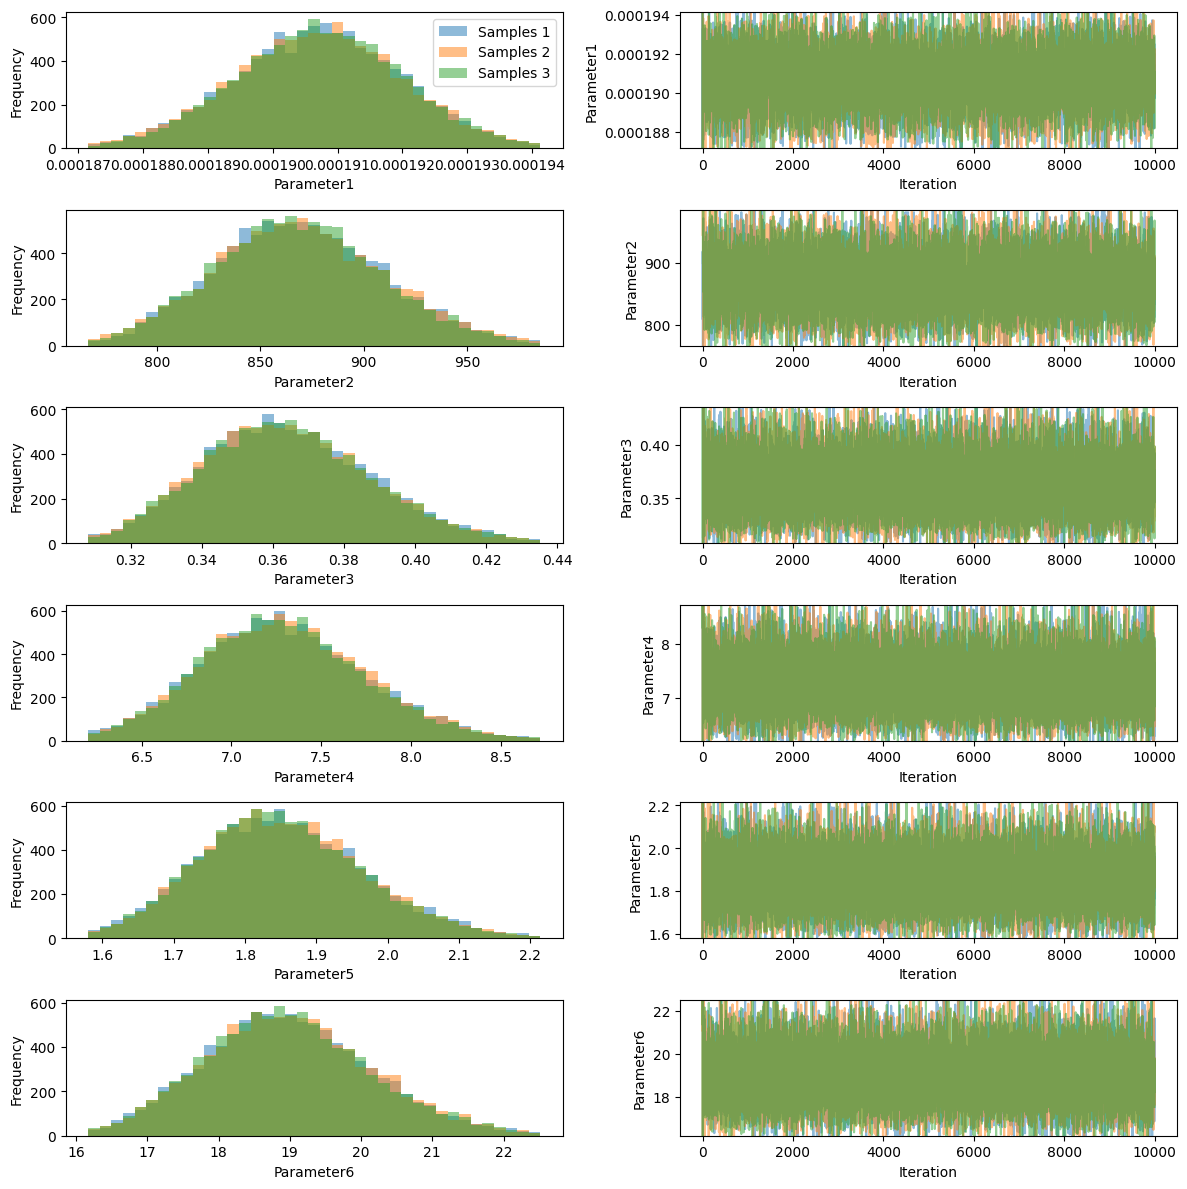

In [13]:

pints.plot.trace(chains, n_percentiles=99)
plt.savefig("mcmc.png")
plt.show()


In [23]:

# ITERS = 100
AllChains = chains[0,100:10000,:]
# np.asarray(AllChains)
print(np.shape(AllChains))
print(AllChains[0])
print(AllChains)


(9900, 6)
[1.90756145e-04 8.75293836e+02 3.60082969e-01 8.28626233e+00
 1.94168804e+00 1.77587636e+01]
[[1.90756145e-04 8.75293836e+02 3.60082969e-01 8.28626233e+00
  1.94168804e+00 1.77587636e+01]
 [1.90596875e-04 8.60690207e+02 3.72565014e-01 6.85715151e+00
  1.67367684e+00 1.87668412e+01]
 [1.91852506e-04 8.40730077e+02 3.70609705e-01 7.21452768e+00
  1.72988031e+00 1.83850755e+01]
 ...
 [1.89696564e-04 8.34136093e+02 3.76133253e-01 7.20855278e+00
  1.95877564e+00 1.98723130e+01]
 [1.90682117e-04 8.39961359e+02 3.78069488e-01 7.31639463e+00
  1.76416862e+00 2.16514295e+01]
 [1.90977472e-04 8.58826137e+02 3.73850694e-01 6.99857596e+00
  1.97529838e+00 1.80254982e+01]]


In [24]:

for I in range(3-1):
    AllChains_add = chains[I+1,100:10000,:]
    AllChains = np.concatenate((AllChains,AllChains_add), axis=0)


In [52]:

y0 = np.array([0.0003,900,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 900,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0001, 1500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

y0 = np.array([0.0003, 1500,6,6,6,6])

boundaries_3d = pints.RectangularBoundaries(prior_arr_lower,
    prior_arr_upper)

opt = pints.OptimisationController(log_likelihood, y0, boundaries=boundaries_3d, method=pints.XNES)
opt.set_log_to_screen(False)
y1, g1 = opt.run()
print('Estimated parameters:')
print(y1)

Estimated parameters:
[1.84774453e-04 1.11650838e+03 2.61526603e-01 1.02011436e+01
 7.08423665e-01 5.20180332e+00]
Estimated parameters:
[1.84774453e-04 1.11650836e+03 2.61526614e-01 1.02011437e+01
 7.08423644e-01 5.20180312e+00]
Estimated parameters:
[1.84774453e-04 1.11650837e+03 2.61526609e-01 1.02011429e+01
 7.08423646e-01 5.20180346e+00]
Estimated parameters:
[1.84774454e-04 1.11650836e+03 2.61526599e-01 1.02011428e+01
 7.08423625e-01 5.20180355e+00]


In [53]:
print(log_likelihood([1.84774453e-04, 1.11650838e+03, 2.61526603e-01, 1.02011436e+01,
 7.08423665e-01, 5.20180332e+00]))

AIC = 2*7 - 2*log_likelihood([1.84774453e-04, 1.11650838e+03, 2.61526603e-01, 1.02011436e+01,
 7.08423665e-01, 5.20180332e+00])

print(AIC)

-565.2542184661186
1144.5084369322371


In [ ]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.show()

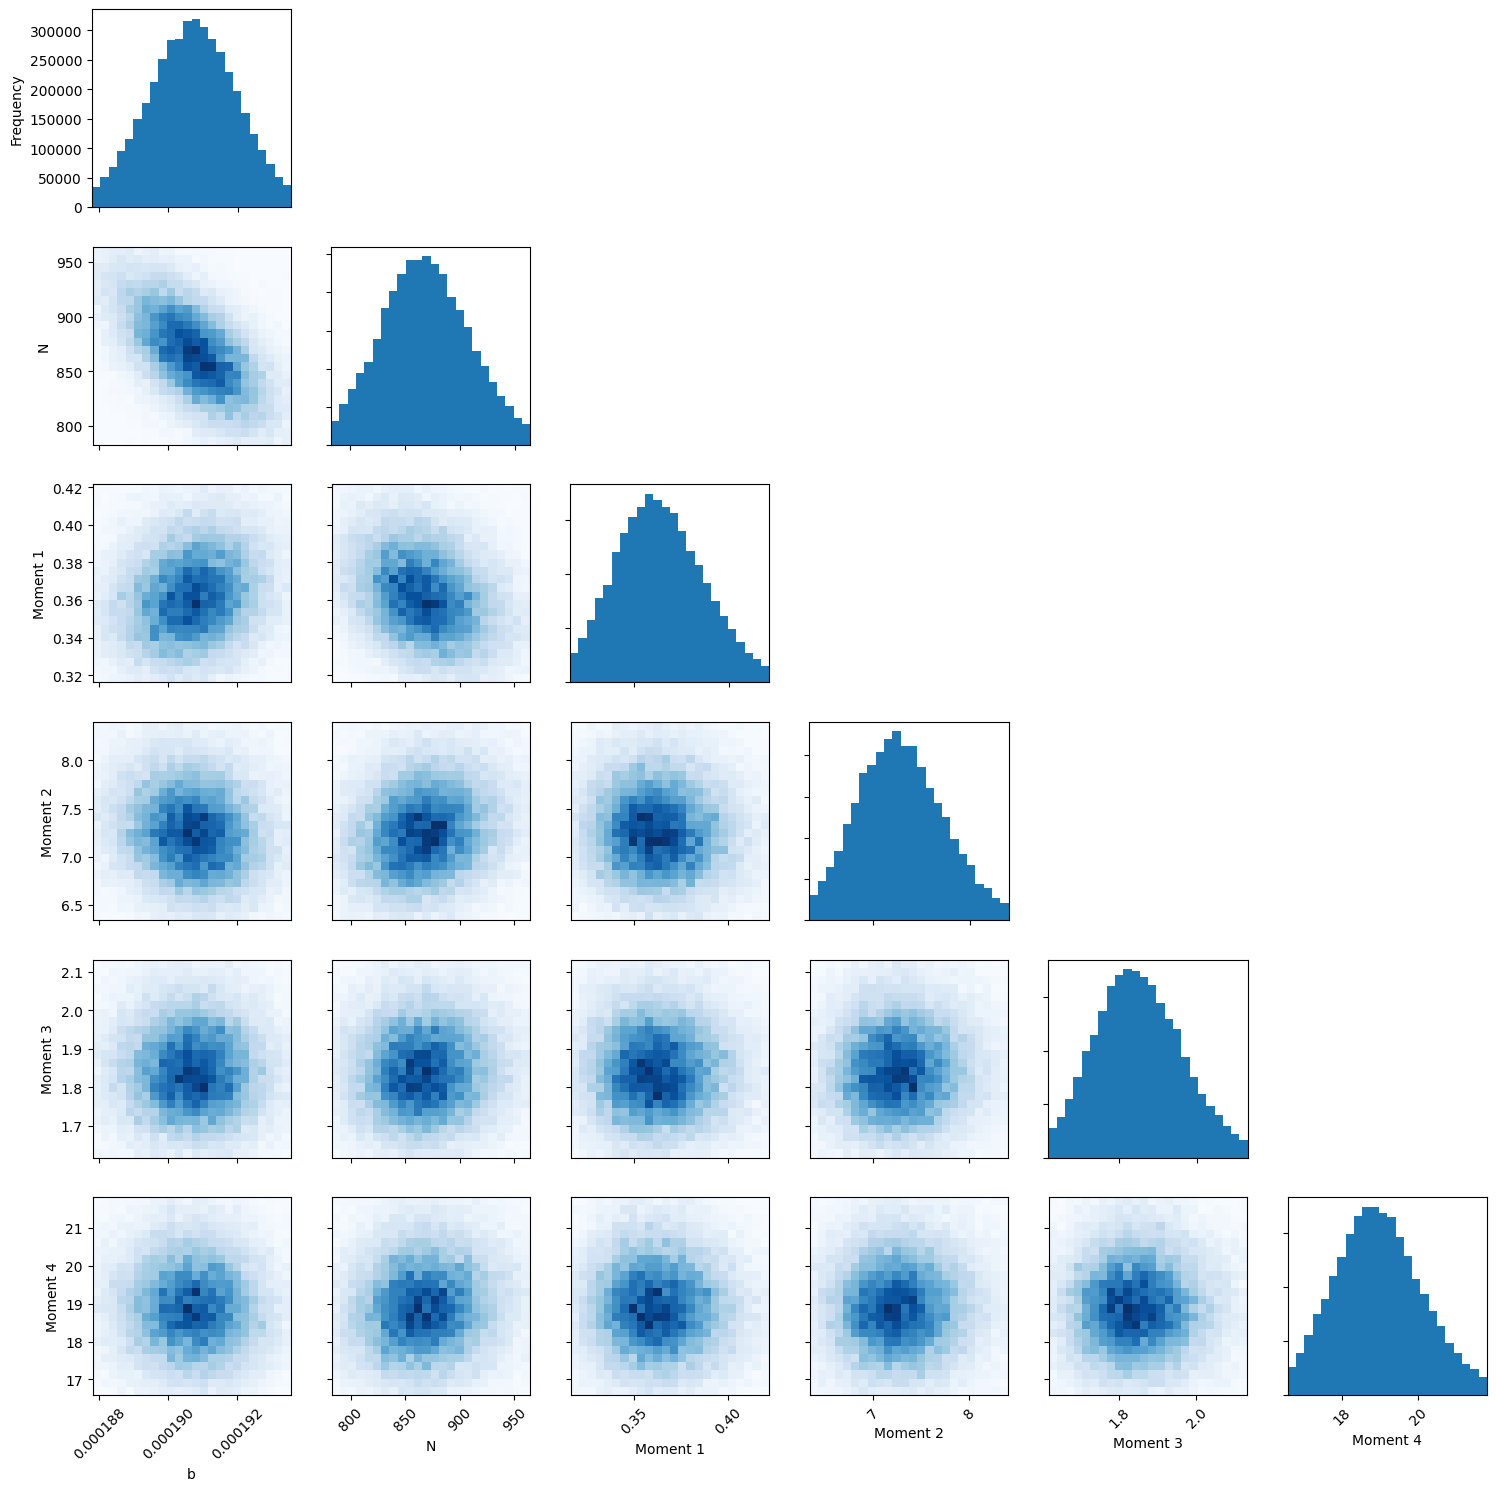

In [26]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"],
                    n_percentiles=97)
                    
plt.show()

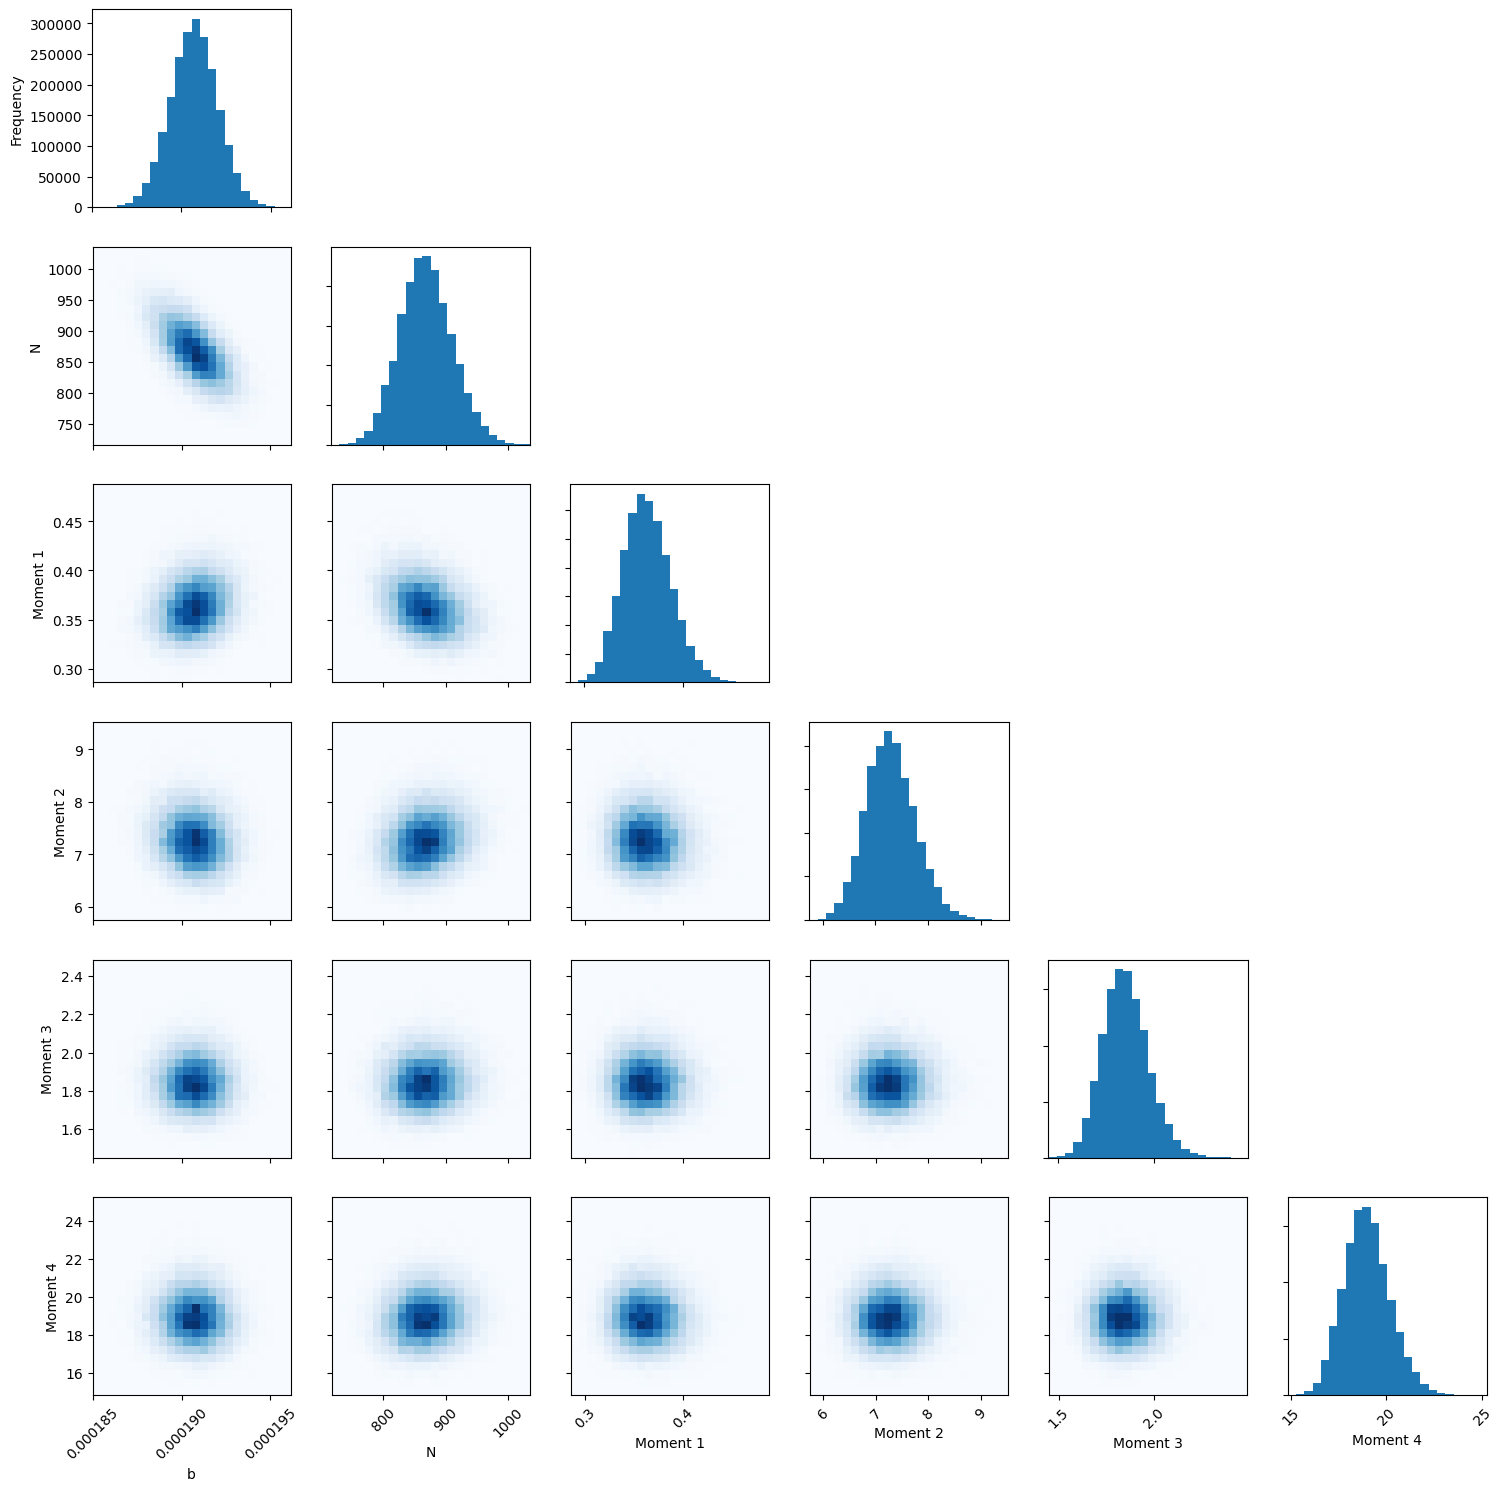

In [59]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)

pints.plot.pairwise(AllChains, heatmap=True, 
                    parameter_names=["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"])
plt.savefig("Pints_basic_pairwise.png", dpi =300)                  
plt.show()

[1.90756145e-04 8.75293836e+02 3.60082969e-01 8.28626233e+00
 1.94168804e+00 1.77587636e+01]


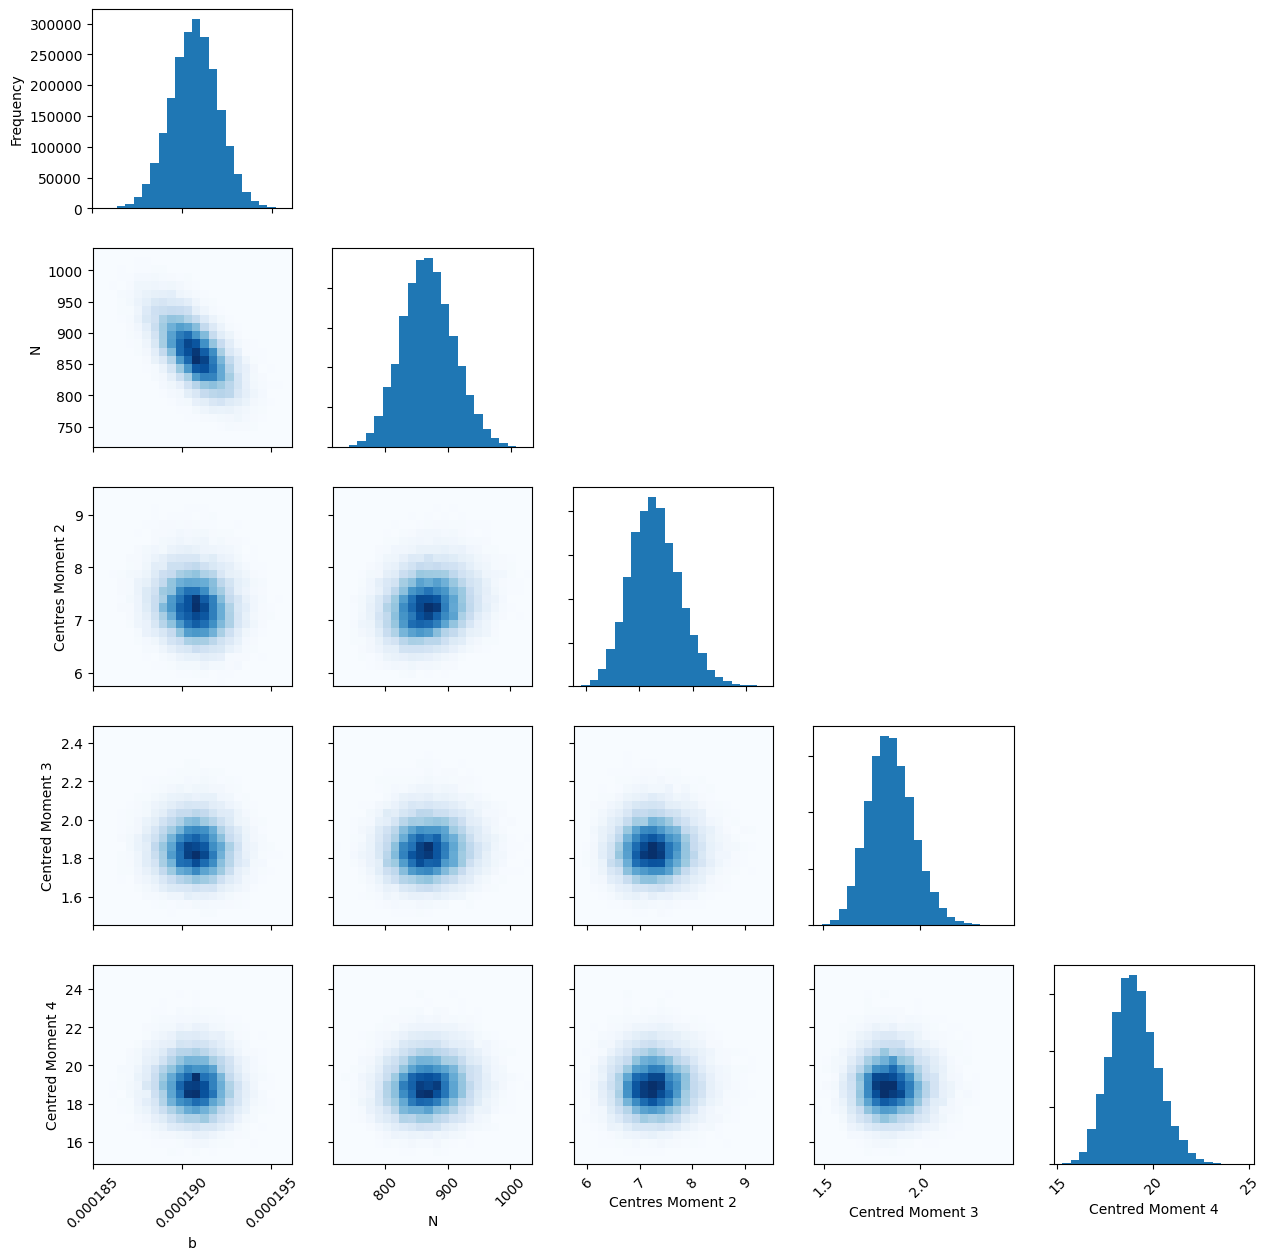

In [27]:
parameter_names = ["b","N", "Moment 2", "Moment 3", "Moment 4"]
#pints.plot.pairwise(chains, kde=True, parameter_names=parameter_names)
print(AllChains[0])
pints.plot.pairwise(AllChains[:,[0,1,3,4,5]], heatmap=True, 
                    parameter_names=["b","N", "Centres Moment 2", "Centred Moment 3", "Centred Moment 4"])
plt.savefig("Pints_pairwise.png", dpi =300)
plt.show()


In [28]:
parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = pints.MCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)


<class 'pints._mcmc._summary.MCMCSummary'>
param     mean    std.    2.5%    25%     50%     75%     97.5%    rhat    ess      ess per sec.
--------  ------  ------  ------  ------  ------  ------  -------  ------  -------  --------------
b         0.00    0.00    0.00    0.00    0.00    0.00    0.00     1.00    3473.76  0.49
N         869.15  42.07   789.65  840.42  867.95  897.19  954.04   1.00    3298.07  0.46
Moment 1  0.36    0.02    0.32    0.35    0.36    0.38    0.42     1.00    4448.19  0.62
Moment 2  7.29    0.47    6.43    6.96    7.27    7.59    8.28     1.00    4713.27  0.66
Moment 3  1.85    0.12    1.64    1.77    1.85    1.93    2.11     1.00    4734.04  0.66
Moment 4  18.99   1.21    16.78   18.17   18.93   19.76   21.52    1.00    4831.74  0.68


In [29]:
from tabulate import tabulate
class MyMCMCSummary(pints.MCMCSummary):
    def __str__(self):
        """
        Prints posterior summaries for all parameters to the console, including
        the parameter name, posterior mean, posterior std deviation, the
        2.5%, 25%, 50%, 75% and 97.5% posterior quantiles, rhat, effective
        sample size (ess) and ess per second of run time.
        """
        if self._summary_str is None:
            headers = [
                'param', 'mean', 'std.',
                '2.5%', '25%', '50%', '75%', '97.5%',
                'rhat', 'ess']
            if self._time is not None:
                headers.append('ess per sec.')

            self._summary_str = tabulate(
                self._summary_list,
                headers=headers,
                numalign='left',
                floatfmt='.3g',
            )

        return self._summary_str
    


In [30]:

parameter_names = ["b","N", "Moment 1", "Moment 2", "Moment 3", "Moment 4"]
results = MyMCMCSummary(chains=chains[:,int(ITERS/2):, :], time=mcmc.time(),
                            parameter_names = parameter_names)
print(type(results))
print(results)

<class '__main__.MyMCMCSummary'>
param     mean      std.      2.5%      25%      50%       75%       97.5%     rhat    ess       ess per sec.
--------  --------  --------  --------  -------  --------  --------  --------  ------  --------  --------------
b         0.000191  1.32e-06  0.000188  0.00019  0.000191  0.000192  0.000193  1       3.47e+03  0.487
N         869       42.1      790       840      868       897       954       1       3.3e+03   0.462
Moment 1  0.364     0.0247    0.32      0.347    0.363     0.38      0.416     1       4.45e+03  0.623
Moment 2  7.29      0.473     6.43      6.96     7.27      7.59      8.28      1       4.71e+03  0.661
Moment 3  1.85      0.119     1.64      1.77     1.85      1.93      2.11      1       4.73e+03  0.664
Moment 4  19        1.21      16.8      18.2     18.9      19.8      21.5      1       4.83e+03  0.677


In [57]:
results.mean()

print(len(results.mean()))

AIC = 2*len(results.mean()) - 2*log_likelihood(results.mean())

print(AIC)

6
1378.9808891235193


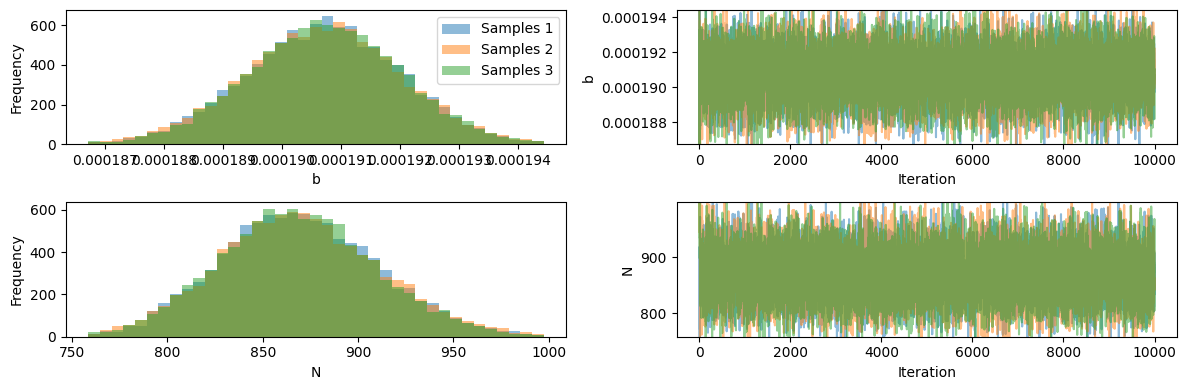

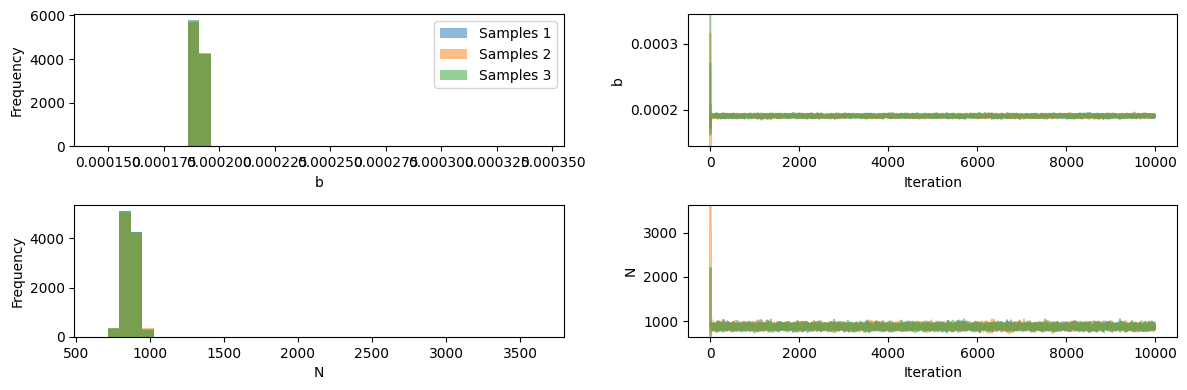

In [49]:
pints.plot.trace(chains[:,:,[0,1]], n_percentiles=99.5, parameter_names=["b","N"])
plt.savefig("pints_out_extremes_removed.png", dpi=300)
plt.show()
pints.plot.trace(chains[:,:,[0,1]], parameter_names=["b","N"])
plt.savefig("pints_out.png", dpi=300)
plt.show()

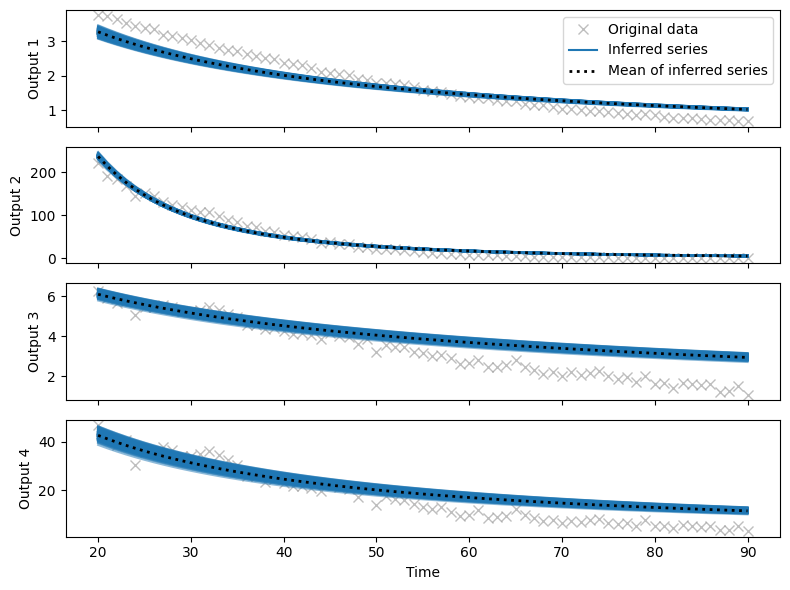

In [54]:
fig, axes = pints.plot.series(AllChains, problem)